In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from statistics import linear_regression
import matplotlib.pyplot as plt
import plorts

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from matplotlib.lines import Line2D

import energy_analysis_helpers

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-fp38knps because the default path (/home/sarslan/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
FIG_SIZE = (8,5)
FIG_SIZE_HALF = (4,4.7)
plt.rcParams["figure.figsize"] = FIG_SIZE
FONT_SIZE = 16
LINE_STYLE = (0,(4,4))
LINE_WIDTH = 3.5
SAVE_FIG = False

In [3]:
N_CORES_TOT = 32

EXP_ID = '230524-1158'
data_folder = '../data/' + EXP_ID + '/'
exp_filename = data_folder + 'energy.log'

if (SAVE_FIG):
    out_dir = '../outputs/' + EXP_ID + '/'
    if (not os.path.exists(out_dir)):
        os.mkdir(out_dir)

# Reading the Experiment Data

In [4]:
exp_df = energy_analysis_helpers.read_energy_log(exp_filename)
exp_df['energy_J'] = exp_df['energy_uJ'] / 1000000
exp_df = energy_analysis_helpers.read_iperf_log(exp_df, data_folder)
exp_df

,cc,mtu,bitrate,n_core,duration,cnt,energy_uJ,energy_J,total_cpu_util_percent,user_cpu_util_percent,system_cpu_util_percent,time_sec,sent_bytes,bps,rtx_pkts,min_rtt,mean_rtt,max_rtt,max_cwnd
0,stress,9000,0,0,10.0,1,2.348596e+08,234.859567,NaN,NaN,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,stress,9000,0,0,10.0,2,2.128971e+08,212.897099,NaN,NaN,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,stress,9000,0,0,10.0,3,2.219296e+08,221.929608,NaN,NaN,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,stress,9000,0,0,10.0,4,2.107860e+08,210.786020,NaN,NaN,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,stress,9000,0,0,10.0,5,2.310167e+08,231.016682,NaN,NaN,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4317,cubic,9000,10,24,100.0,6,1.156185e+10,11561.846683,96.863017,2.401998,94.461022,100.000117,1.228548e+11,9.828375e+09,2463.0,1.126,1.243,1.361,1539056.0
4318,cubic,9000,10,24,100.0,7,1.159283e+10,11592.828171,99.107230,2.712203,96.395031,100.000134,1.193934e+11,9.551455e+09,1303.0,0.271,0.803,1.335,1718016.0
4319,cubic,9000,10,24,100.0,8,1.156537e+10,11565.374812,97.048425,2.358970,94.689462,100.000072,1.231359e+11,9.850861e+09,2593.0,1.191,1.280,1.369,1753808.0
4320,cubic,9000,10,24,100.0,9,1.158624e+10,11586.242556,97.100455,2.358178,94.742277,100.000108,1.229387e+11,9.835087e+09,2614.0,1.180,1.197,1.215,1592744.0


# Energy Consumption Analysis

In [5]:
energy_per_time_df = []
for cca, df in exp_df.groupby('cc'):
    if (cca in ['stress', 'sleep']):
        for n_core, ddf in df.groupby('n_core'):
            slope, _ = linear_regression(ddf['time_sec'], ddf['energy_J'], proportional=True)
            energy_per_time_df.append([cca, 0, n_core, slope])
    else:
        for bitrate, ddf in df.groupby('bitrate'):
            for n_core, dddf in ddf.groupby('n_core'):
                slope, _ = linear_regression(dddf['time_sec'], dddf['energy_J'], proportional=True)
                energy_per_time_df.append([cca, bitrate, n_core, slope])
energy_per_time_df = pd.DataFrame(energy_per_time_df, columns=['cc', 'bitrate', 'n_core', 'power_W'])
energy_per_time_df

,cc,bitrate,n_core,power_W
0,cubic,1,0,31.719964
1,cubic,1,8,90.392880
2,cubic,1,16,111.816159
3,cubic,1,24,114.567092
4,cubic,2,0,32.653717
5,cubic,2,8,90.225669
6,cubic,2,16,110.277264
7,cubic,2,24,114.701690
8,cubic,3,0,33.887252
9,cubic,3,8,90.606683


In [6]:
overhead_energy = \
    energy_per_time_df[energy_per_time_df.cc=='stress'][['n_core', 'power_W']].copy().set_index('n_core').to_dict()['power_W']
energy_per_time_df['power_W_noOverhead'] = \
    energy_per_time_df.apply(lambda row: row['power_W'] - overhead_energy[row['n_core']], axis=1)

In [7]:
matrix = energy_per_time_df.pivot(index='bitrate', columns='n_core', values='power_W')
print('=== Power Consumption of Traffic and Background Cores (W) ===\n')
print(matrix)

=== Power Consumption of Traffic and Background Cores (W) ===

n_core          0          8           16          24
bitrate                                              
0        21.491975  89.602671  110.458654  114.331136
1        31.719964  90.392880  111.816159  114.567092
2        32.653717  90.225669  110.277264  114.701690
3        33.887252  90.606683  111.300222  114.879697
4        33.767618  90.886280  111.345270  115.021340
5        34.233544  90.988624  111.784315  115.224964
6        34.820963  91.291811  111.714939  115.426839
7        35.546627  91.676493  112.274762  115.610328
8        35.855886  91.781788  112.115905  115.769130
9        36.689721  92.161443  112.346051  115.884470
10       35.823146  92.637712  112.355918  115.735262


In [8]:
matrix = energy_per_time_df.pivot(index='bitrate', columns='n_core', values='power_W_noOverhead')
print('=== Power Consumption of Traffic Only (W) ===\n')
print(matrix)

=== Power Consumption of Traffic Only (W) ===

n_core          0         8         16        24
bitrate                                         
0         0.000000  0.000000  0.000000  0.000000
1        10.227989  0.790209  1.357505  0.235956
2        11.161742  0.622998 -0.181390  0.370554
3        12.395277  1.004011  0.841567  0.548561
4        12.275643  1.283609  0.886616  0.690204
5        12.741569  1.385953  1.325661  0.893828
6        13.328988  1.689140  1.256284  1.095703
7        14.054652  2.073821  1.816107  1.279192
8        14.363911  2.179116  1.657251  1.437995
9        15.197746  2.558772  1.887397  1.553334
10       14.331171  3.035040  1.897264  1.404126


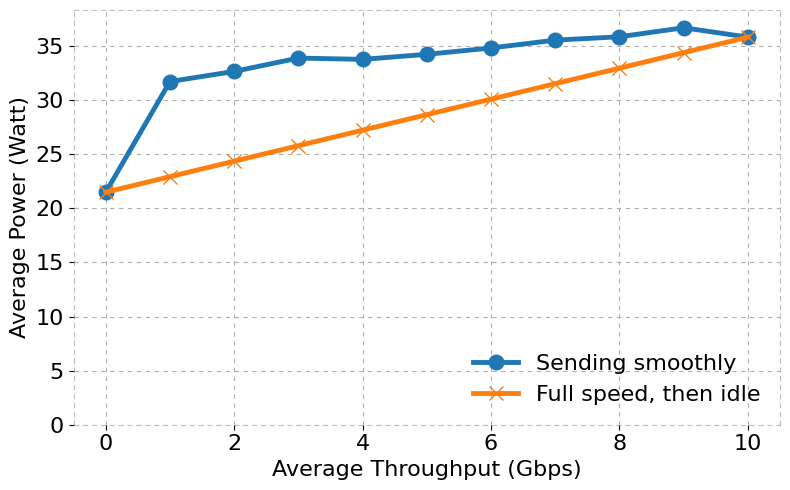

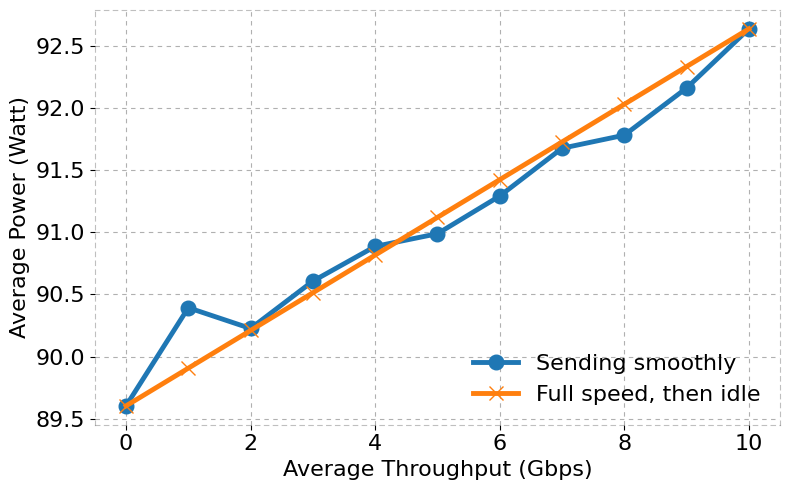

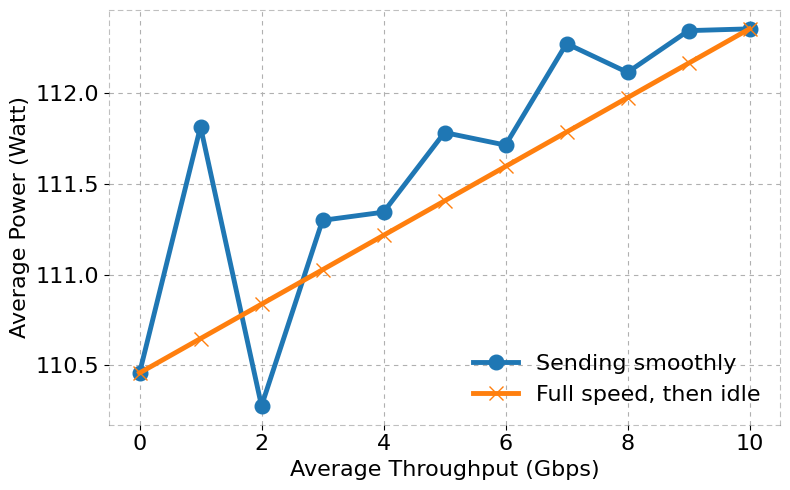

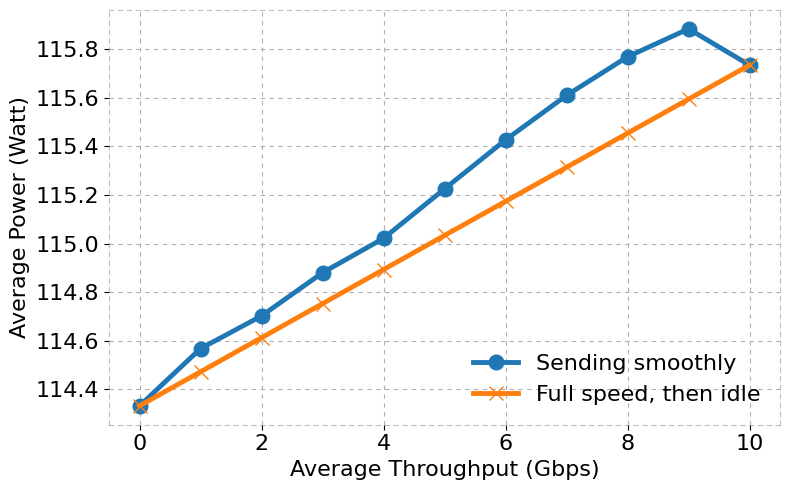

In [9]:
for n_core,df in energy_per_time_df.sort_values(by='bitrate').groupby('n_core'):
    idle_power_W = df[df.bitrate == 0].power_W.iloc[0]
    max_power_W = df[df.bitrate == 10].power_W.iloc[0]
    df['power_W_per_gb'] = df.power_W*1/df.bitrate + idle_power_W*(1 - 1/df.bitrate)
    df['W_full_speed'] = max_power_W*df.bitrate/10. + idle_power_W*(1 - df.bitrate/10.)

    plt.figure(figsize=FIG_SIZE)
    plt.plot(df.bitrate, df.power_W, marker='o', label='Sending smoothly', 
             linewidth=LINE_WIDTH, markersize=LINE_WIDTH*3)
    plt.plot(df.bitrate, df.W_full_speed, marker='x', label='Full speed, then idle', 
             linewidth=LINE_WIDTH, markersize=LINE_WIDTH*3)
    plt.ylabel("Average Power (Watt)", fontsize=FONT_SIZE)
    plt.xlabel("Average Throughput (Gbps)", fontsize=FONT_SIZE)
    plt.legend(loc='best')
    plt.xticks(fontsize=FONT_SIZE)
    plt.yticks(fontsize=FONT_SIZE)
    if (n_core == 0):
        plt.ylim((0,df.W_full_speed.max()*1.07))
    plt.xticks(rotation = 0)
    plt.grid(linestyle=LINE_STYLE)
    leg = plt.gca().legend(loc='lower right', frameon=False, fontsize=FONT_SIZE)
    # plt.setp(leg.get_title(),fontsize=FONT_SIZE)
    plt.gca().spines["right"].set_linestyle(LINE_STYLE)
    plt.gca().spines["right"].set_alpha(0.5)
    plt.gca().spines["right"].set_color('gray')
    plt.gca().spines["left"].set_linestyle(LINE_STYLE)
    plt.gca().spines["left"].set_alpha(0.5)
    plt.gca().spines["left"].set_color('gray')
    # plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["top"].set_linestyle(LINE_STYLE)
    plt.gca().spines["top"].set_alpha(0.5)
    plt.gca().spines["top"].set_color('gray')
    # plt.gca().spines["bottom"].set_visible(False)
    plt.gca().spines["bottom"].set_linestyle(LINE_STYLE)
    plt.gca().spines["bottom"].set_alpha(0.5)
    plt.gca().spines["bottom"].set_color('gray')

    plt.tight_layout()
    # plt.subplots_adjust(right=0.3, top=0.1, bottom=0.05)

    if (SAVE_FIG):
        plt.savefig( out_dir + '/smooth_vs_bursty_{}_cores.pdf'.format(n_core))

    plt.show()

In [10]:
# for n_core,df in energy_per_time_df.sort_values(by='bitrate').groupby('n_core'):
#     idle_kJps = df[df.bitrate == 0].kJps.iloc[0]
#     max_kJps = df[df.bitrate == 10].kJps.iloc[0]
#     df['kJ_per_gb'] = df.kJps*1/df.bitrate + idle_kJps*(1 - 1/df.bitrate)
#     df['kJ_full_speed'] = max_kJps*df.bitrate/10. + idle_kJps*(1 - df.bitrate/10.)

#     plt.figure(figsize=FIG_SIZE)
#     plt.plot(df.bitrate, df.kJps, marker='o',
#              linewidth=LINE_WIDTH, markersize=LINE_WIDTH*3)
#     plt.ylabel("Average Rate of Energy (KJ/sec)", fontsize=FONT_SIZE)
#     plt.xlabel("Average Throughput (Gbps)", fontsize=FONT_SIZE)
#     plt.xticks(fontsize=FONT_SIZE)
#     plt.yticks(fontsize=FONT_SIZE)
#     if (n_core == 0):
#         plt.ylim((0,df.kJ_full_speed.max()*1.07))
#     plt.xticks(rotation = 0)
#     plt.grid(linestyle=LINE_STYLE)
#     # plt.setp(leg.get_title(),fontsize=FONT_SIZE)
#     plt.gca().spines["right"].set_linestyle(LINE_STYLE)
#     plt.gca().spines["right"].set_alpha(0.5)
#     plt.gca().spines["right"].set_color('gray')
#     plt.gca().spines["left"].set_linestyle(LINE_STYLE)
#     plt.gca().spines["left"].set_alpha(0.5)
#     plt.gca().spines["left"].set_color('gray')
#     # plt.gca().spines["top"].set_visible(False)
#     plt.gca().spines["top"].set_linestyle(LINE_STYLE)
#     plt.gca().spines["top"].set_alpha(0.5)
#     plt.gca().spines["top"].set_color('gray')
#     # plt.gca().spines["bottom"].set_visible(False)
#     plt.gca().spines["bottom"].set_linestyle(LINE_STYLE)
#     plt.gca().spines["bottom"].set_alpha(0.5)
#     plt.gca().spines["bottom"].set_color('gray')

#     plt.tight_layout()
#     # plt.subplots_adjust(right=0.3, top=0.1, bottom=0.05)

#     plt.show()

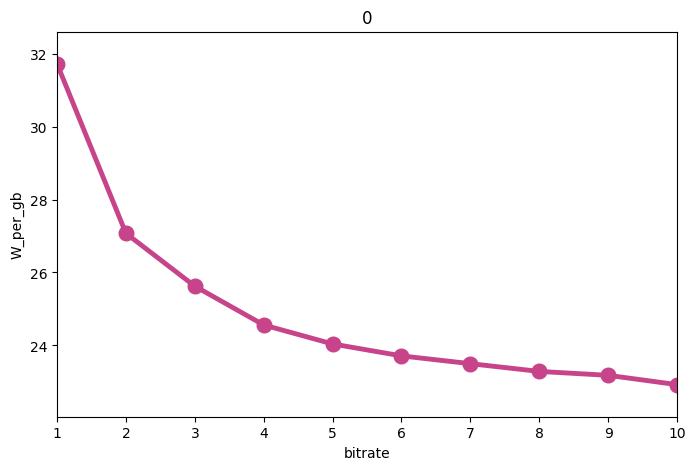

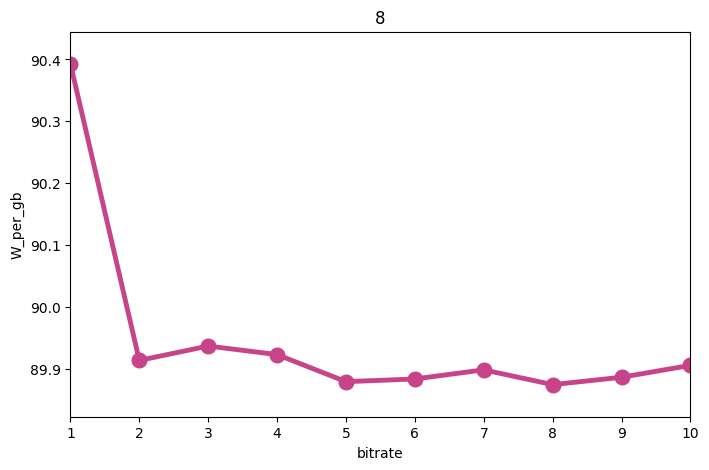

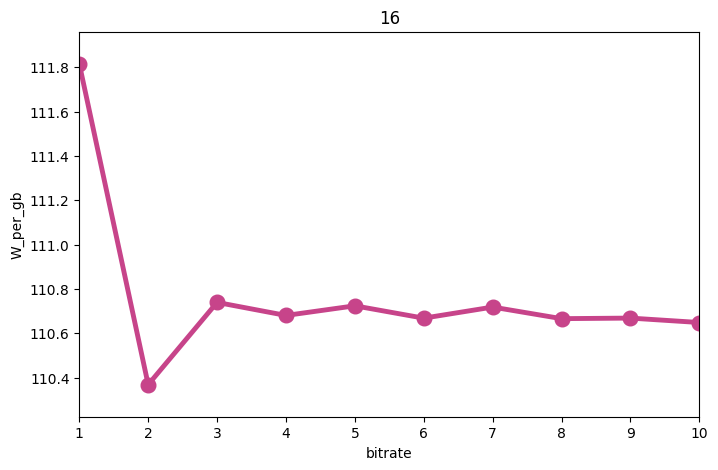

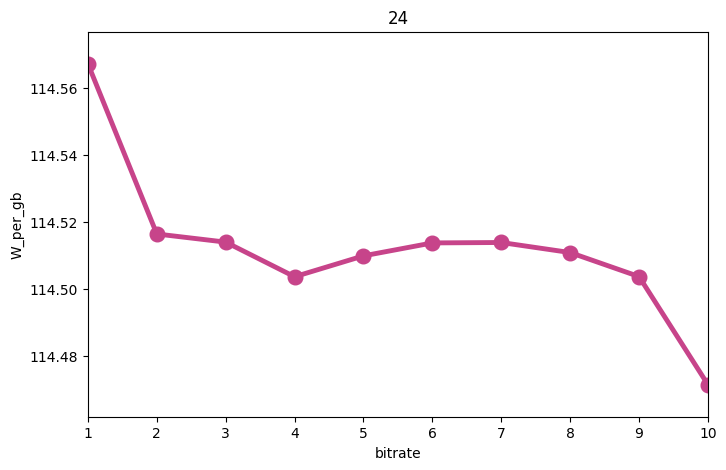

In [11]:
for n_core,df in energy_per_time_df.sort_values(by='bitrate').groupby('n_core'):
    idle_power_W = df[df.bitrate == 0].power_W.iloc[0]
    df['W_per_gb'] = df.power_W*1/df.bitrate + idle_power_W*(1 - 1/df.bitrate)
    plt.figure()
    plt.title(n_core)
    plorts.plot(df, x='bitrate', y='W_per_gb', marker='o', 
                linewidth=LINE_WIDTH, markersize=LINE_WIDTH*3)

In [12]:
energy_per_bitrate = {}
for _,row in energy_per_time_df[energy_per_time_df.n_core == 0].iterrows():
    energy_per_bitrate[row.bitrate] = row.power_W
energy_per_bitrate

{1: 31.719963701042722,
 2: 32.65371743697132,
 3: 33.88725223939299,
 4: 33.76761809126857,
 5: 34.23354410422375,
 6: 34.82096343011955,
 7: 35.546627268588495,
 8: 35.85588564926029,
 9: 36.68972089567139,
 10: 35.82314646982251,
 0: 21.49197500574026}

In [13]:
capacity = 10
file_size = capacity
duration = 2 * file_size / capacity
df = []
for fg_share_gbps in range(0,11):
    bg_share_gbps = capacity - fg_share_gbps
    if bg_share_gbps < fg_share_gbps:
        fct = file_size / fg_share_gbps
    else:
        fct = file_size / bg_share_gbps
        
    fg_left_to_send = file_size - fg_share_gbps * fct
    fg_full_time = fg_left_to_send / capacity
    fg_idle_time = duration - fct - fg_full_time
    fg_energy = energy_per_bitrate[fg_share_gbps]*fct + energy_per_bitrate[0]*fg_idle_time + energy_per_bitrate[10] * fg_full_time
    bg_left_to_send = file_size - bg_share_gbps*fct
    bg_full_time = bg_left_to_send / capacity
    bg_idle_time = duration - fct - bg_full_time
    bg_energy = energy_per_bitrate[bg_share_gbps]*fct + energy_per_bitrate[0]*bg_idle_time + energy_per_bitrate[10]*bg_full_time
    df.append({
        'capacity': capacity,
        'fct': fct,
        'fg_share_gbps':fg_share_gbps,
        'fg_idle_time':fg_idle_time,
        'fg_full_time': fg_full_time,
        'fg_energy':fg_energy,
        'bg_share_gbps':bg_share_gbps,
        'bg_left_to_send':bg_left_to_send,
        'bg_full_time':bg_full_time,
        'bg_idle_time':bg_idle_time,
        'bg_energy':bg_energy
    })
df = pd.DataFrame(df)
df['total_energy'] = df['fg_energy'] + df['bg_energy']
df

,capacity,fct,fg_share_gbps,fg_idle_time,fg_full_time,fg_energy,bg_share_gbps,bg_left_to_send,bg_full_time,bg_idle_time,bg_energy,total_energy
0,10,1.000000,0,0.000000e+00,1.000000,57.315121,10,0.000000,0.000000,1.000000e+00,57.315121,114.630243
1,10,1.111111,1,-1.110223e-16,0.888889,67.087201,9,0.000000,0.000000,8.888889e-01,59.870334,126.957535
2,10,1.250000,2,0.000000e+00,0.750000,67.684507,8,0.000000,0.000000,7.500000e-01,60.938838,128.623345
3,10,1.428571,3,0.000000e+00,0.571429,68.880730,7,0.000000,0.000000,5.714286e-01,63.062025,131.942754
4,10,1.666667,4,-5.551115e-17,0.333333,68.220412,6,0.000000,0.000000,3.333333e-01,65.198931,133.419343
5,10,2.000000,5,0.000000e+00,0.000000,68.467088,5,0.000000,0.000000,0.000000e+00,68.467088,136.934176
6,10,1.666667,6,3.333333e-01,0.000000,65.198931,4,3.333333,0.333333,-5.551115e-17,68.220412,133.419343
7,10,1.428571,7,5.714286e-01,0.000000,63.062025,3,5.714286,0.571429,0.000000e+00,68.880730,131.942754
8,10,1.250000,8,7.500000e-01,0.000000,60.938838,2,7.500000,0.750000,0.000000e+00,67.684507,128.623345
9,10,1.111111,9,8.888889e-01,0.000000,59.870334,1,8.888889,0.888889,-1.110223e-16,67.087201,126.957535


(0.0, 10.0, 0.0, 139.16456976347195)

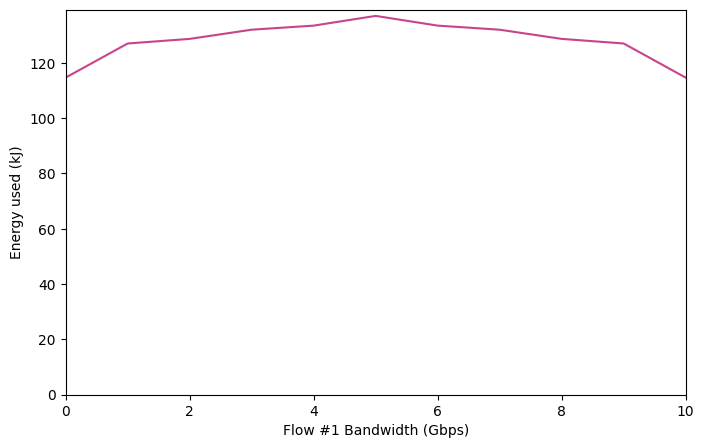

In [14]:
plorts.plot(df, x="fg_share_gbps", y='total_energy')
plt.xlabel("Flow #1 Bandwidth (Gbps)")
plt.ylabel("Energy used (kJ)")
plt.axis(ymin=0)

In [15]:
# fair_energy = df[df.fg_share_gbps == 5].iloc[0].total_energy
# df['energy_savings_pct'] = 100.0*(df['total_energy'] - fair_energy)/fair_energy
# df['fg_share_pct'] = 10*df['fg_share_gbps']

# plorts.plot(df, x="fg_share_pct", y='energy_savings_pct')
# plt.ylabel("% energy used over fair share")
# plt.xlabel("% bandwidth used by Flow #1")
# plt.axhline(y=0, linestyle=":", color='grey')
# plt.axvline(x=50, linestyle=":", color='grey')
# plt.text(52, -10, "Fair share", size=15)
# plorts.style_axis()

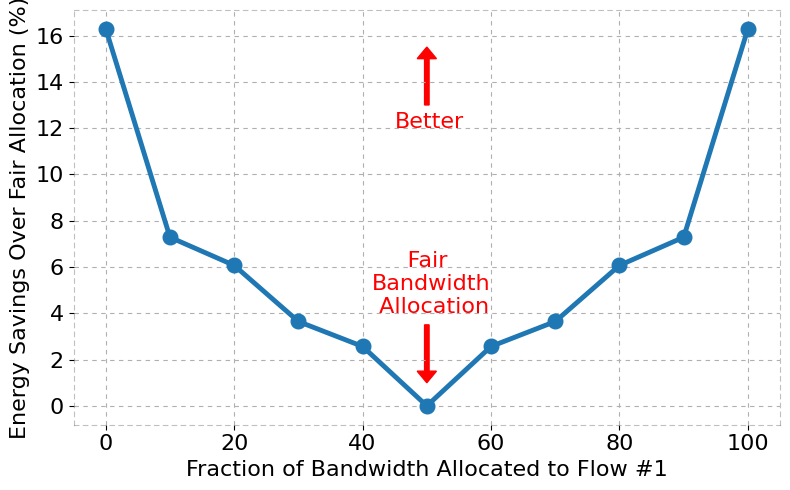

In [16]:
fair_energy = df[df.fg_share_gbps == 5].iloc[0].total_energy
df['energy_savings_pct'] = 100.0*(fair_energy - df['total_energy'])/fair_energy
df['fg_share_pct'] = 10*df['fg_share_gbps']

plt.figure(figsize=FIG_SIZE)
plt.plot(df.fg_share_pct, df.energy_savings_pct, marker='o', 
             linewidth=LINE_WIDTH, markersize=LINE_WIDTH*3)

plt.ylabel("Energy Savings Over Fair Allocation (%)", fontsize=FONT_SIZE)
plt.xlabel("Fraction of Bandwidth Allocated to Flow #1", fontsize=FONT_SIZE)
plt.arrow(50, 3.5, 0, -2, head_width=3, color='red', head_length=0.5, width=0.7)
plt.text(41.5, 4, "     Fair\nBandwidth\n Allocation", size=FONT_SIZE, color='red')
plt.arrow(50, 13, 0, 2, head_width=3, color='red', head_length=0.5, width=0.7)
plt.text(45, 12, "Better", size=FONT_SIZE, color='red')

plt.xticks(fontsize=FONT_SIZE)
plt.yticks(fontsize=FONT_SIZE)
plt.grid(linestyle=LINE_STYLE)
plt.gca().spines["right"].set_linestyle(LINE_STYLE)
plt.gca().spines["right"].set_alpha(0.5)
plt.gca().spines["right"].set_color('gray')
plt.gca().spines["left"].set_linestyle(LINE_STYLE)
plt.gca().spines["left"].set_alpha(0.5)
plt.gca().spines["left"].set_color('gray')
# plt.gca().spines["top"].set_visible(False)
plt.gca().spines["top"].set_linestyle(LINE_STYLE)
plt.gca().spines["top"].set_alpha(0.5)
plt.gca().spines["top"].set_color('gray')
# plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["bottom"].set_linestyle(LINE_STYLE)
plt.gca().spines["bottom"].set_alpha(0.5)
plt.gca().spines["bottom"].set_color('gray')

plt.tight_layout()

if (SAVE_FIG):
    plt.savefig( out_dir + '/fairness_vs_energy.pdf')

plt.show()

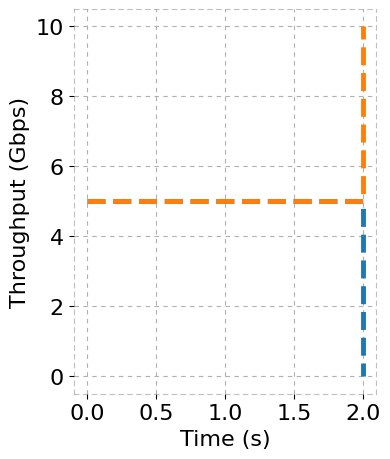

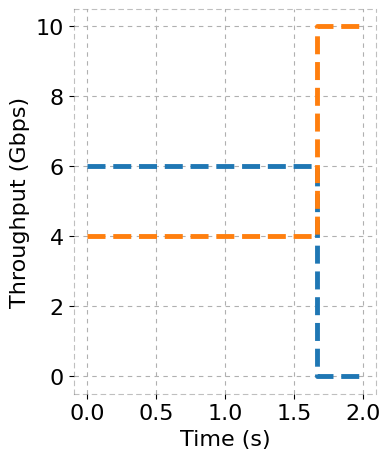

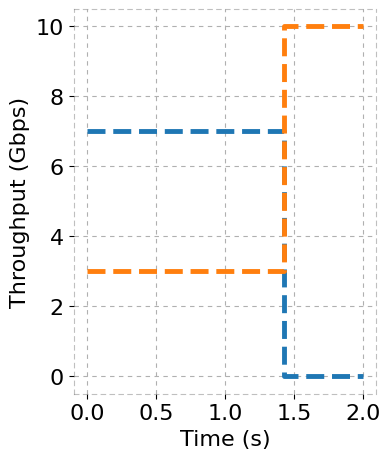

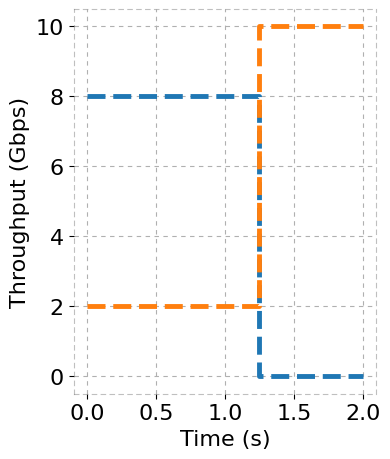

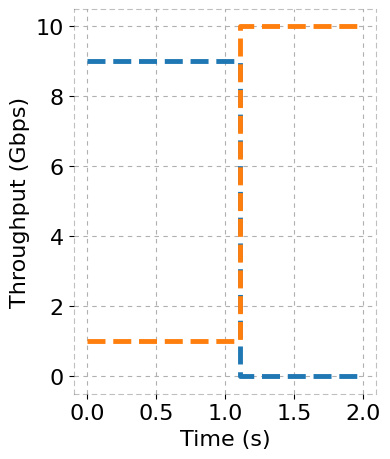

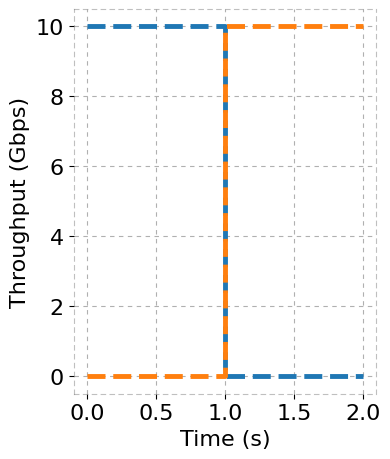

In [17]:
for _,exp in df.iterrows():
    if exp.fg_share_gbps < 5: continue
    plt.figure(figsize=FIG_SIZE_HALF)
    # plt.title(f"Flow #1 share: {exp.fg_share_gbps.astype(int)} Gbps")
    plt.plot([0, exp.fct, exp.fct, exp.fct + exp.bg_full_time], [exp.fg_share_gbps, exp.fg_share_gbps, 0, 0],
             '--', label="Flow #1", linewidth=LINE_WIDTH)
    plt.plot([0, exp.fct, exp.fct, exp.fct + exp.bg_full_time], [exp.bg_share_gbps, exp.bg_share_gbps, exp.capacity, exp.capacity],
             '--', label="Flow #2", linewidth=LINE_WIDTH)
    plt.xlabel("Time (s)", fontsize=FONT_SIZE)
    plt.ylabel("Throughput (Gbps)", fontsize=FONT_SIZE)

    plt.xticks(fontsize=FONT_SIZE)
    plt.yticks(fontsize=FONT_SIZE)
    plt.grid(linestyle=LINE_STYLE)
    plt.gca().spines["right"].set_linestyle(LINE_STYLE)
    plt.gca().spines["right"].set_alpha(0.5)
    plt.gca().spines["right"].set_color('gray')
    plt.gca().spines["left"].set_linestyle(LINE_STYLE)
    plt.gca().spines["left"].set_alpha(0.5)
    plt.gca().spines["left"].set_color('gray')
    # plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["top"].set_linestyle(LINE_STYLE)
    plt.gca().spines["top"].set_alpha(0.5)
    plt.gca().spines["top"].set_color('gray')
    # plt.gca().spines["bottom"].set_visible(False)
    plt.gca().spines["bottom"].set_linestyle(LINE_STYLE)
    plt.gca().spines["bottom"].set_alpha(0.5)
    plt.gca().spines["bottom"].set_color('gray')

    plt.tight_layout()

    if (SAVE_FIG):
        plt.savefig( out_dir + '/experiment_trace_{:.0f}_gbps.pdf'.format(exp.fg_share_gbps))
    
    plt.show()

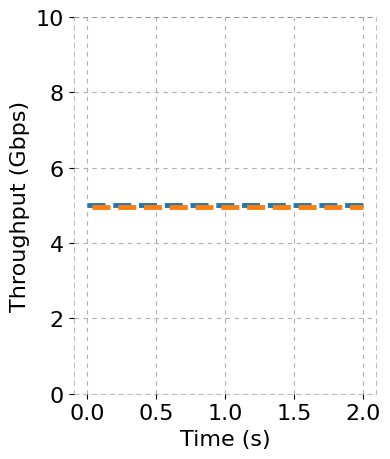

In [18]:
exp = df.iloc[5]

plt.figure(figsize=FIG_SIZE_HALF)
# plt.title(f"Flow #1 share: {exp.fg_share_gbps.astype(int)} Gbps")
plt.plot([0, exp.fct], [exp.fg_share_gbps, exp.fg_share_gbps], '--', label="Flow #1", linewidth=LINE_WIDTH)
plt.plot([0.03, exp.fct], [exp.bg_share_gbps-0.05, exp.bg_share_gbps-0.05], '--', label="Flow #2", linewidth=LINE_WIDTH)
plt.axis(ymin=0,ymax=10)
plt.xlabel("Time (s)", fontsize=FONT_SIZE)
plt.ylabel("Throughput (Gbps)", fontsize=FONT_SIZE)

plt.xticks(fontsize=FONT_SIZE)
plt.yticks(fontsize=FONT_SIZE)
plt.grid(linestyle=LINE_STYLE)
plt.gca().spines["right"].set_linestyle(LINE_STYLE)
plt.gca().spines["right"].set_alpha(0.5)
plt.gca().spines["right"].set_color('gray')
plt.gca().spines["left"].set_linestyle(LINE_STYLE)
plt.gca().spines["left"].set_alpha(0.5)
plt.gca().spines["left"].set_color('gray')
# plt.gca().spines["top"].set_visible(False)
plt.gca().spines["top"].set_linestyle(LINE_STYLE)
plt.gca().spines["top"].set_alpha(0.5)
plt.gca().spines["top"].set_color('gray')
# plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["bottom"].set_linestyle(LINE_STYLE)
plt.gca().spines["bottom"].set_alpha(0.5)
plt.gca().spines["bottom"].set_color('gray')

plt.tight_layout()

if (SAVE_FIG):
        plt.savefig( out_dir + f'/experiment_trace_{exp.fg_share_gbps.astype(int)}_gbps.pdf')

plt.show()